# Read MRAW (cihx) file from slow motion camera

In [1]:
import pyMRAW
import h5py
import os
import cv2
from tqdm import tqdm 
import numpy as np
import time
import gc
import psutil
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

Run in Server

In [ ]:
# Define paths
main_path = os.path.join("P:", "DBW experiments - sediment flume - HL TU Delft (29 May 2023 - 30 Aug 2023)", 
                         "experimental data", "videos", "recordings_sideview")
main_path_store = os.path.join('P:', "videodata", "sideview", "sedimentFlume")

# Process illumination directories
for illumination in os.listdir(main_path):
    if 'illumination' not in illumination:
        continue
        
    print(f"Processing {illumination}")
    for root, dirs, files in os.walk(os.path.join(main_path, illumination)):
        if dirs and os.path.basename(root).startswith('FC'):
            new_dir = os.path.join(main_path_store, illumination, os.path.basename(root))
            for dir in dirs:
                os.makedirs(os.path.join(new_dir, dir), exist_ok=True)
                
        # Process CIHX files
        for file in files:
            if not file.endswith(".cihx"):
                continue
                
            save_path = os.path.join(main_path_store, illumination, os.path.basename(root))
            file_path = os.path.join(root, file)
            print(f"Loading: {file_path}")
            
            # Load and save video
            images, info = pyMRAW.load_video(file_path)
            filename = os.path.join(save_path, file.split('cihx')[0]) + "h5"
            
            # Save with compression
            start = time.time()
            with h5py.File(filename, "w") as f:
                f.create_dataset("array", data=images, compression="gzip", compression_opts=1)
            save_time = time.time() - start
            
            # Report metrics
            file_size = os.path.getsize(filename) / (1024**2)
            print(f"Saved: {filename} | {file_size:.2f} MB | {save_time:.2f}s")
            
            # Free memory
            del images
            gc.collect()

Run locally

In [ ]:
# path = os.path.join('/', "Volumes", "staff-umbrella", "dam break wave experiments",
#                             "videos_sideview_sedimentFlume", "incident_illumination", 
#                             "FC4_h0=128mm","Side_View_Video_128mm_MRAW_015_C001H001S0001") #Path of the one cihx file
path = os.path.join('/', "Volumes", "staff-umbrella", "dam break wave experiments",
                            "videos_sideview_sedimentFlume", "back_illumination", 
                            "FC4_h0=128mm","Side_View_Video_BI_128mm_MRAW_test015_C001H001S0001") #Path of the one cihx file

illumination= "back_illumination" if "back_illumination" in path else "incident_illumination"

# Create output directory if it doesn't exist
input_dir = os.path.join(os.path.expanduser("~"), "Desktop", "imgs")
os.makedirs(input_dir, exist_ok=True)
output_dir = os.path.join(os.path.expanduser("~"), "Desktop", "imgs_processed")
os.makedirs(output_dir, exist_ok=True)

Test for single file

In [ ]:
for file in os.listdir(path):
    if file.endswith(".cihx"):
        print("Loading file: ", file)
        images, info = pyMRAW.load_video(path+'/'+file) #Takes ±1h per file in macOS

Loading file:  Side_View_Video_BI_128mm_MRAW_test015_C001H001S0001.cihx


/opt/anaconda3/envs/runpod/lib/python3.12/site-packages/pyMRAW.py:104: UserWarning: Clipped footage! (Total frame: 20488, Original total frame: 43666)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))
/opt/anaconda3/envs/runpod/lib/python3.12/site-packages/pyMRAW.py:128: UserWarning: 12bit images will be loaded into memory!
  warnings.warn("12bit images will be loaded into memory!")


In [4]:
# print(info)
# print("Size of images: ", images.shape) #±21k frames
# print("Size of one frame: ", images[0].shape)

{'Date': '2023/8/23', 'Camera Type': 'FASTCAM Nova S16 type 1100K-M-64GB 10GbE model', 'Record Rate(fps)': 16000.0, 'Shutter Speed(s)': 60000.0, 'Total Frame': 20488, 'Original Total Frame': 43666, 'Image Width': 1024, 'Image Height': 1024, 'File Format': 'Mraw', 'EffectiveBit Depth': 12, 'EffectiveBit Side': 'Lower', 'Color Bit': 12, 'Comment Text': ''}
Size of images:  (20488, 1024, 1024)
Size of one frame:  (1024, 1024)


Gzip compression levels from 1 to 9:
- Lower values (1-3) → Faster saving, larger files.
- Medium values (4-6, default 4) → Balanced speed & size.
- Higher values (7-9) → Smallest file size, slowest save time.

In [ ]:
#Save the datasets
filename = os.path.join(path, f"data_gzip.h5")

# Measure save time
start = time.time()
with h5py.File(filename, "w") as f:
    f.create_dataset("array", data=images, compression="gzip", compression_opts=1)
save_time = time.time() - start

# Measure file size
file_size = os.path.getsize(filename) / (1024**2)  # Convert to MB

print(f"Level 1: {file_size:.2f} MB | Save: {save_time:.2f}s")

# Clean up memory after save loop (optional)
del images
gc.collect()

- Level 1 results in 19100.30 MB and takes 683-1446.48s to save and 2030.22s to load
- Level 9 results in 17866.30 MB and takes 16868.11s to save

In [ ]:
# #Load the datasets
# filename = os.path.join(path, f"data_gzip.h5")

# # Measure load time
# start = time.time()
# with h5py.File(filename, "r") as f:
#     data = f["array"][:]
# load_time = time.time() - start

# # Clear loaded data to free memory
# del data
# gc.collect()

# print(f"Level 1: Load: {load_time:.2f}s")

# Convert from raw to png (different preprocessing for incident and back illumination)

Functions to save individual frames and combined images

In [4]:
def display_image(title, img, save_path=None):
    cv2.namedWindow(title, cv2.WINDOW_NORMAL)
    # cv2.imshow(title, img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # cv2.waitKey(1)
    if save_path:
        cv2.imwrite(save_path, img)

def create_combined_image(images_list, display_image, save_name='combined_image_incident_illumination.png'):
    # Ensure all images are 3-channel (convert grayscale to BGR)
    images_list = [(title, cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) if len(img.shape) == 2 else img) for title, img in images_list]

    # Ensure all images have the same height
    height = min(img.shape[0] for _, img in images_list)
    resized_images = [(title, cv2.resize(img, (int(img.shape[1] * height / img.shape[0]), height))) for title, img in images_list]

    # Create a blank space for titles
    title_height = 100
    title_image = np.ones((title_height, sum(img.shape[1] for _, img in resized_images), 3), dtype=np.uint8) * 255

    # Add titles to the blank space
    x_offset = 0
    for title, img in resized_images:
        text_size = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 2)[0]
        text_x = x_offset + (img.shape[1] - text_size[0]) // 2
        text_y = (title_height + text_size[1]) // 2
        cv2.putText(title_image, title, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)
        x_offset += img.shape[1]

    # Concatenate the title image with the actual images
    combined_image = np.vstack([title_image, np.hstack([img for _, img in resized_images])])

    # Save and display
    display_image('combined_images', combined_image, save_name)

Incident Illumination

In [ ]:
def normalize_and_clahe(img, clip_limit=10.0, tile_grid_size=(8,8)):
    img_norm = img_as_ubyte(img / img.max())
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img_norm)

if illumination == "incident_illumination":
    img_rotated_background, img_rotated = None, None #To avoid errors in do not exist

    for i, img in tqdm(enumerate(images), total=len(images), desc="Saving frames"):
        if i == 0:
            img_rotated_background = cv2.rotate(normalize_and_clahe(img), cv2.ROTATE_90_CLOCKWISE)
            display_image('Background_incident_illumination', img_rotated_background)
        
        if 6000 < i < 6002:
            img_rotated = cv2.rotate(normalize_and_clahe(img), cv2.ROTATE_90_CLOCKWISE)
            display_image('Image', img_rotated)

    print(f"Saved {i} frame to {output_dir}")

    diff = cv2.absdiff(img_rotated_background, img_rotated)
    display_image("Difference", diff)#, 'difference_incident_illumination.png')

    clahe_img_noise = normalize_and_clahe(diff)
    display_image('Difference_clahe_incident_illumination', clahe_img_noise)#, 'noise_check_clahe_incident_illumination.png')

    diff_blur = cv2.GaussianBlur(diff, (3, 3), 0)
    _, thresholded = cv2.threshold(diff_blur, 20, 255, cv2.THRESH_BINARY)
    result = cv2.bitwise_and(diff, diff, mask=thresholded)
    display_image('Difference_thresholded_incident_illumination', result)#, 'difference_incident_illumination_noise_removed.png')

    clahe_img = normalize_and_clahe(result)
    display_image('Difference_thresholded_clahe_incident_illumination', clahe_img)#, 'clahe_noise_removed_incident_illumination.png')

    #Create a combined image with the titles
    # Load the images with their titles
    images_list = [
        ("Background", img_rotated_background),
        ("Wave", img_rotated),
        ("Difference", diff),
        ("CLAHE Noise Check", clahe_img_noise),
        ("Noise Removed", result),
        ("CLAHE Noise Removed", clahe_img),
    ]

    create_combined_image(images_list, display_image, save_name='combined_image_incident_illumination.png')

Saving frames: 100%|██████████| 20488/20488 [00:02<00:00, 8937.61it/s]


Saved 20487 frame to /Users/nikolaossourlo/Desktop/imgs


Back Illumination

In [ ]:
if illumination == "back_illumination":
    # Define parameters
    gamma = 2.5
    contrast_dark = 0.15  # Increased contrast for dark areas
    contrast_bright = 0.3  # Lowered contrast for bright areas
    brightness = 0.00
    gain = 1.8
    threshold = 128

    # Precompute gamma correction lookup table
    gamma_correction_table = np.array([(i / 255.0) ** (1 / gamma) * 255 for i in np.arange(256)]).astype("uint8")

    def adaptive_contrast(img, threshold):
        mask_bright = img > threshold
        mask_dark = ~mask_bright
        img_adjusted = np.zeros_like(img, dtype=np.float32)
        img_adjusted[mask_bright] = img[mask_bright] * contrast_bright
        img_adjusted[mask_dark] = img[mask_dark] * contrast_dark
        return np.clip(img_adjusted, 0, 255).astype(np.uint8)

    def process_frame(img):
        img_32bit = img.astype('float32')
        img_gamma_corrected = cv2.LUT(cv2.convertScaleAbs(img_32bit), gamma_correction_table)
        img_contrast_adaptive = adaptive_contrast(img_gamma_corrected, threshold)
        img_hdr = np.clip(img_contrast_adaptive * gain, 0, 255).astype(np.uint8)
        return cv2.rotate(img_hdr, cv2.ROTATE_90_CLOCKWISE)

    for i, img in tqdm(enumerate(images), total=len(images), desc="Saving frames"):
        if i == 0:
            img_rotated_background = process_frame(img)

        img_rotated = process_frame(img)

        diff = cv2.absdiff(img_rotated_background, img_rotated)

        clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
        clahe_img_noise = clahe.apply(diff)

        # Noise removal
        diff_blur = cv2.GaussianBlur(diff, (3, 3), 0)
        _, thresholded = cv2.threshold(diff_blur, 20, 255, cv2.THRESH_BINARY)
        result = cv2.bitwise_and(diff, diff, mask=thresholded)
        display_image('Noise Removed', result, input_dir+"/"+f"frame_0{str(i).zfill(3)}.jpg")#'difference_back_illumination_noise_removed.png')

        clahe_img = clahe.apply(result)

        # Load the images with their titles
        images_list = [
            ("Background", img_rotated_background),
            ("Wave", img_rotated),
            ("Difference", diff),
            ("CLAHE Noise Check", clahe_img_noise),
            ("Noise Removed", result),
            ("CLAHE Noise Removed", clahe_img),
        ]

        #Create a combined image with the titles
        if i in range((len(images)-1)//2, (len(images)+3)//2): #Just very few saves of full images since large (5MB each)
            create_combined_image(images_list, display_image, save_name=output_dir+"/"+'combined_image_back_illumination_'+f"frame_0{str(i).zfill(3)}"+'.png')

Saving frames: 100%|██████████| 20488/20488 [07:06<00:00, 48.00it/s]


# Columns for elevation changes (only tested on back illumination)

In the implementation below the individual bubbles on top of the wave are included in the column calculations (white_pixels = np.where(column > 0)[0])

First frame: frame_0000.jpg
Width, height: 1024 1024
Column_positions: [100, 306, 512, 718, 924]


Getting columns: 100%|██████████| 20488/20488 [00:38<00:00, 533.09it/s]


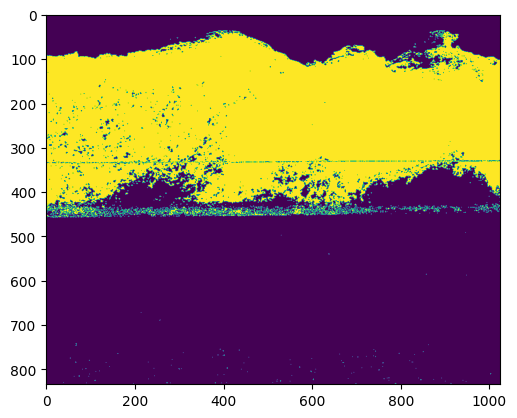

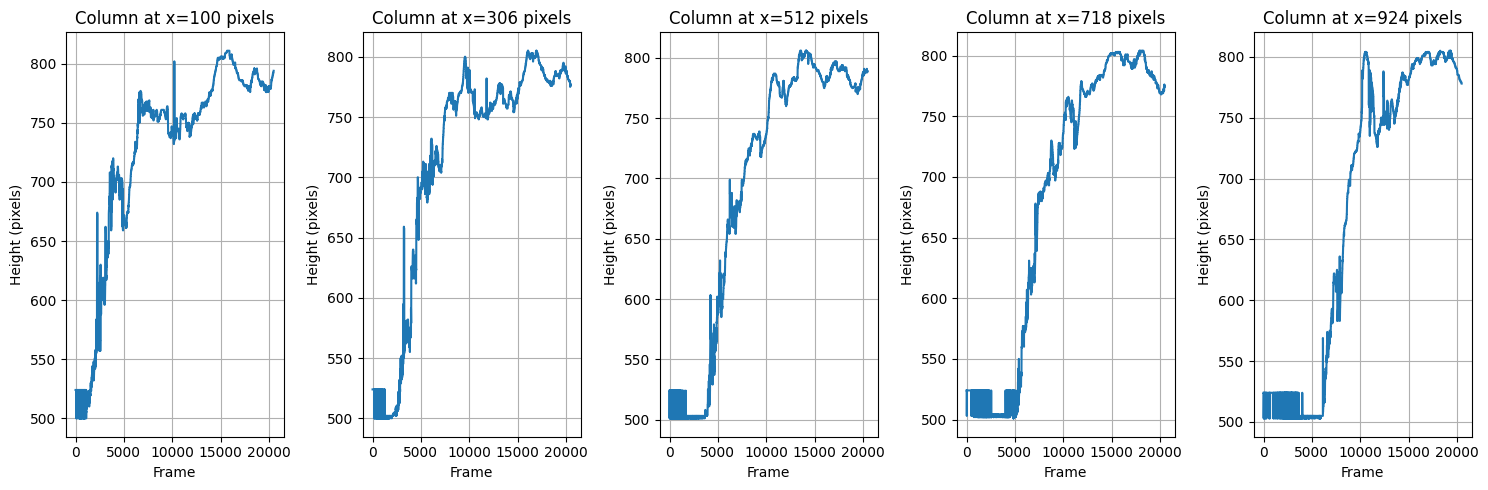

In [13]:
# Parameters
skip_top_pixels = 190 #number of pixels to skip from the top
middle_wave_height = 500 #Used to get only the upper contour of the wave
threshold_level=10 #0-255 - If 0 too pixelated due to transforming tiny noise to blobs
w = 1 #width of each column in pixels
bin_start = 100 #Start 1st column after that many pixels
bin_end = 200 #End with the nth column that half of that many pixels before the end of img
n_columns = 5 #number of equally spaced columns to analyze (min 2)

n_frames = len([f for f in os.listdir(input_dir) if f.startswith('frame_0') and f.endswith('.jpg')])

# Calculate column positions (n_columns equally spaced columns)
frame_files = sorted([f for f in os.listdir(input_dir) if f.startswith('frame_0') and f.endswith('.jpg')])
first_frame = frame_files[0]
print(f"First frame: {first_frame}")

img = cv2.imread(os.path.join(input_dir, first_frame), cv2.IMREAD_GRAYSCALE)
height, width = img.shape
print("Width, height:", width, height)
column_positions = [bin_start + i * (width - bin_end) // (n_columns-1) for i in range(n_columns)]  # n_columns equally spaced positions
print("Column_positions:", column_positions)

# Initialize arrays to store highest pixel positions
bin_arrays = [[] for _ in range(n_columns)]

# Process each frame
for frame_num in tqdm(range(0, n_frames), desc="Getting columns"):
    frame_path = os.path.join(input_dir, f"frame_0{str(frame_num).zfill(3)}.jpg")
        
    # Read and threshold the image
    img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, threshold_level, 255, cv2.THRESH_BINARY)
    # plt.imshow(thresh[skip_top_pixels:,:])
    
    # Process each column
    for i, col_center in enumerate(column_positions):
        # Extract column - Based on width starting and ending point is decided
        col_start = max(0, col_center - w//2)
        col_end = min(width, col_center + w//2 + (w % 2))  # Added w % 2 to handle odd widths
        column = thresh[skip_top_pixels:, col_start:col_end]
        
        # Find highest white pixel
        white_pixels = np.where(column > 0)[0]
        if len(white_pixels) > 0:
            highest_point = white_pixels[0] + skip_top_pixels # First white pixel from top
        else:
            highest_point = height  # If no white pixels found, use bottom of image
            # print("bottom of image", highest_point)
            
        if height - highest_point<middle_wave_height:
            highest_point = middle_wave_height

        bin_arrays[i].append(int(height - highest_point))  # Convert to distance from bottom (bottom till upper part of the img)
        #400 has noise and middle of the wave is at 500. Therefore, wave is when above 500+
        # if height-highest_point>510: #Index is the frame when wave reaches that column
        #     print("Index",frame_num, 'column', i, 'height is:', height-highest_point) #Prints from 1k+ for col 0, and from ±2k for col 1

        # Use middle frame for column position visualization
        middle_frame_num = n_frames // 2
        if frame_num == middle_frame_num:
            plt.imshow(thresh[skip_top_pixels:,:])
            # Convert threshold image to BGR so we can draw colored rectangles
            thresh_bgr = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            
            # Draw a green rectangle for each column position
            for col_center in column_positions:
                col_start = max(0, col_center - w//2)
                col_end = min(width, col_center + w//2 + (w % 2))
                cv2.rectangle(thresh_bgr,
                            (col_start, 0),  # top-left point
                            (col_end, height),  # bottom-right point 
                            (0, 255, 0),  # BGR color (green)
                            2)  # Reduced thickness to better see the columns
                cv2.rectangle(img_bgr,
                            (col_start, 0),  # top-left point
                            (col_end, height),  # bottom-right point 
                            (0, 255, 0),  # BGR color (green)
                            2)  # Reduced thickness to better see the columns

            # Save both images with columns overlaid
            output_path = os.path.join(output_dir, f"columns_frame_{middle_frame_num:04d}_{w}_pixels_width.jpg")
            cv2.imwrite(output_path, thresh_bgr)
            output_path_orig = os.path.join(output_dir, f"columns_frame_original_{middle_frame_num:04d}_{w}_pixels_width.jpg")
            cv2.imwrite(output_path_orig, img_bgr)

# Create the plot
plt.figure(figsize=(15, 5))
frames = range(1, len(bin_arrays[0]) + 1)
for i in range(n_columns):
    plt.subplot(1, n_columns, i+1)
    plt.plot(frames, bin_arrays[i])
    plt.title(f'Column at x={column_positions[i]} pixels')
    plt.xlabel('Frame')
    plt.ylabel('Height (pixels)')
    plt.grid(True)  # Add grid for better readability

plt.tight_layout()
plt.savefig(output_dir+'/'+"time_series_graph_"+str(w)+"_pixels_width"+".png", dpi=300, bbox_inches='tight')  # Save with higher quality
plt.show()

# Save bin_arrays for each column as npy files
for i in range(n_columns):
    output_path = os.path.join(output_dir, f'bin_array_column_{column_positions[i]}_pixels.npy')
    np.save(output_path, np.array(bin_arrays[i]))

# Wave roller

Getting columns:  23%|██▎       | 4685/20488 [00:05<00:17, 912.53it/s] 



First frame with area above 100000 pixels: Frame 4685


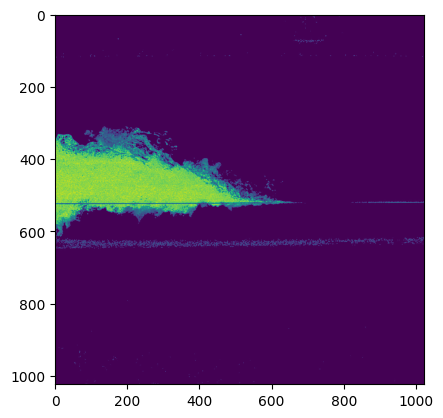

In [14]:
def detect_roller_area(frame):
    _, thresh = cv2.threshold(frame, 10, 255, cv2.THRESH_BINARY)
    return np.sum(thresh > 0)  # Nonzero pixels as area estimate

# Find first frame with area above 100000 (sum of pixel intensities 0-255)
threshold_area = 100000
first_large_frame = None

# Skip top n pixels when calculating area
for frame_num in tqdm(range(0, n_frames), desc="Getting columns"):
    frame_path = os.path.join(input_dir, f"frame_0{str(frame_num).zfill(3)}.jpg")
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    # Skip top n pixels
    # frame = frame[skip_top_pixels:, :]
    area = detect_roller_area(frame)
    
    if area > threshold_area:
        first_large_frame = frame_num
        break

if first_large_frame is not None:
    print(f"\nFirst frame with area above {threshold_area} pixels: Frame {first_large_frame}")
    plt.imshow(frame)
else:
    print(f"\nNo frames found with area above {threshold_area} pixels")

In [ ]:
# Initialize arrays to store frames and contours
all_frames = []
all_contours = []

prev_area = None
threshold = 50000  # Adjust based on expected contour size change - This will inform us of errors
start_row = 190 #Cut the n pixels at the top of the image
end_row = -400 #Cut the n pixels at the bottom of the image
within_y_pixels = 50 # Check if points are within n pixels in y
close_points_x = 30  # Only connect consecutive points if they're close enough (within close_points_x pixels)

flag=0

for frame_num in tqdm(range(first_large_frame, n_frames), desc="Getting columns"): #(len(images)-1)//2, (len(images)+3)//2)):
    frame_path = os.path.join(input_dir, f"frame_0{str(frame_num).zfill(3)}.jpg")
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

    if frame is None:
        continue

    gray = frame[start_row:end_row, :]

    # Apply thresholding (Adaptive to handle changing lighting) - Just a simple threshold on original image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean noise
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)

        # Check for a sudden spike in detected area
        if prev_area is not None and abs(area - prev_area) > threshold:
            print(f"Warning: Sudden change in contour area at frame {frame_num}")
            continue
        prev_area = area

        # Get bounding box and filter invalid contours
        x_min, y_min, width, height = cv2.boundingRect(largest_contour)
        
        if width > 0.999 * gray.shape[1] and flag==0:  # If the wave roller gets out of the frame stop finding contours
            flag=1
            continue

        elif flag==0: #Keep detecting contours

            # Find the rightmost point
            rightmost = tuple(largest_contour[largest_contour[:,:,0].argmax()][0])
            x, y = rightmost
            y += start_row  # Adjust for ROI offset

            # Create dictionary to store highest points for each x coordinate
            highest_points = {}
            points=[]
            for point in largest_contour:
                px, py = point[0]
                py_adjusted = py + start_row  # Adjust for ROI offset
                
                # Only consider points with x>10 (due to lines in the beginning of the img changing contour) and those that are above the wave roller (red point)
                if px > 5 and py_adjusted < y and px < x:
                    # Update if this is the highest point for this x coordinate
                    if px not in highest_points or py < highest_points[px]:
                        highest_points[px] = py

                    points.append([px,py])

            
            # Convert dictionary to filtered list of points with continuity check
            filtered_points = []
            prev_x = None
            prev_y = None
            
            for px in sorted(highest_points.keys()):
                curr_y = highest_points[px]
                
                if prev_x is not None:
                    # Check if points are within n pixels in y
                    if abs(curr_y - prev_y) > within_y_pixels:
                        continue
                    
                    # Add point only if it's continuous
                    filtered_points.append([[px, curr_y]])
                else:
                    # First valid point
                    filtered_points.append([[px, curr_y]])
                
                prev_x = px
                prev_y = curr_y

            # Create visualization frame
            vis_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            
            # Create contour visualization frame
            contour_vis = np.zeros_like(vis_frame)
            
            # Draw the filtered points
            for i in range(len(filtered_points)-1):
                pt1 = tuple(filtered_points[i][0])
                pt2 = tuple(filtered_points[i+1][0])
                # Only connect points if they're close enough
                if abs(pt2[0] - pt1[0]) <= close_points_x: #Lower values will result in non-continuous contours
                    cv2.line(vis_frame[start_row:end_row, :], pt1, pt2, (0, 255, 0), 2)
                    cv2.line(contour_vis[start_row:end_row, :], pt1, pt2, (0, 255, 0), 2)
                
            cv2.circle(vis_frame, (x, y), 5, (0, 0, 255), -1)
            cv2.putText(vis_frame, f"Frame: {frame_num}, Pos: ({x}, {y})", 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            # Store frames
            all_frames.append(vis_frame)
            all_contours.append(contour_vis)

            if output_dir:
                debug_path = os.path.join(output_dir, f'debug_frame_{frame_num:05d}.jpg')
                cv2.imwrite(debug_path, vis_frame)

            cv2.imshow('Wave Tracking', vis_frame)
            cv2.waitKey(1)


# # Convert lists to numpy arrays
# all_frames = np.array(all_frames)
# all_contours = np.array(all_contours)

# print("Visualizing saved frames and contours...")
# for i in tqdm(range(len(all_frames))):
#     # Display original frame with visualization
#     cv2.imshow('Wave Tracking', all_frames[i])
#     # Display contour visualization
#     cv2.imshow('Contours', all_contours[i])
#     cv2.waitKey(1)

cv2.destroyAllWindows()

Getting columns:  32%|███▏      | 4978/15803 [00:45<01:38, 110.03it/s]


KeyboardInterrupt: 

Alternative smoother version

In [38]:
from scipy.signal import savgol_filter

In [48]:
# Initialize arrays to store frames and contours
all_frames = []
all_contours = []

prev_area = None
threshold = 50000  # Adjust based on expected contour size change - This will inform us of errors
start_row = 190 #Cut the n pixels at the top of the image
end_row = -400 #Cut the n pixels at the bottom of the image

flag = 0
prev_filtered_points = None  # Store previous frame's points for continuity

for frame_num in tqdm(range(first_large_frame, n_frames), desc="Getting columns"):
    frame_path = os.path.join(input_dir, f"frame_0{str(frame_num).zfill(3)}.jpg")
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

    if frame is None:
        continue

    gray = frame[start_row:end_row, :]

    # Apply thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean noise
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)

        if prev_area is not None and abs(area - prev_area) > threshold:
            print(f"Warning: Sudden change in contour area at frame {frame_num}")
            continue
        prev_area = area

        x_min, y_min, width, height = cv2.boundingRect(largest_contour)
        
        if width > 0.999 * gray.shape[1] and flag==0:
            flag=1
            continue

        elif flag==0:
            rightmost = tuple(largest_contour[largest_contour[:,:,0].argmax()][0])
            x, y = rightmost
            y += start_row

            # Create complete x-coordinate array
            x_coords = np.arange(0, gray.shape[1])
            y_coords = np.full(gray.shape[1], np.nan)

            # Fill in detected points
            for point in largest_contour:
                px, py = point[0]
                py_adjusted = py + start_row
                if px > 10 and px < x and py_adjusted < y:  # Only process points before the red point
                    y_coords[px] = py

            # Interpolate missing values
            mask = ~np.isnan(y_coords)
            x_valid = x_coords[mask]
            y_valid = y_coords[mask]
            
            if len(x_valid) > 0:
                # Interpolate missing values
                interp_func = np.interp(x_coords[x_coords < x], x_valid, y_valid)  # Only interpolate up to x
                # Apply lighter Savitzky-Golay smoothing to preserve more detail
                if len(x_valid) > 31:  # Reduced window size to capture more detail
                    smoothed_y = savgol_filter(interp_func, window_length=31, polyorder=3)
                else:
                    smoothed_y = interp_func

                # Add small controlled noise to make contour more realistic
                noise = np.random.normal(0, 0.5, len(smoothed_y))  # Very small amplitude noise
                smoothed_y = smoothed_y + noise
                
                # Create filtered points with interpolated and smoothed y coordinates
                filtered_points = [[[int(x), int(y)]] for x, y in zip(x_coords[x_coords < x], smoothed_y)]

                # Light temporal smoothing to avoid jumps while preserving detail
                if prev_filtered_points is not None:
                    alpha = 0.7  # Increased weight for current frame to preserve more detail
                    for i in range(min(len(filtered_points), len(prev_filtered_points))):
                        curr_y = filtered_points[i][0][1]
                        prev_y = prev_filtered_points[i][0][1]
                        # Limit maximum change between frames
                        max_change = 3  # pixels
                        delta = curr_y - prev_y
                        if abs(delta) > max_change:
                            delta = max_change * np.sign(delta)
                        filtered_points[i][0][1] = int(prev_y + delta)

                prev_filtered_points = filtered_points.copy()

                # Create visualization frame
                vis_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                contour_vis = np.zeros_like(vis_frame)
                # Draw the filtered points
                for i in range(len(filtered_points)-1):
                    pt1 = tuple(filtered_points[i][0])
                    pt2 = tuple(filtered_points[i+1][0])
                    cv2.line(vis_frame[start_row:end_row, :], pt1, pt2, (0, 255, 0), 2)
                    cv2.line(contour_vis[start_row:end_row, :], pt1, pt2, (0, 255, 0), 2)
                
                cv2.circle(vis_frame, (x, y), 5, (0, 0, 255), -1)
                cv2.putText(vis_frame, f"Frame: {frame_num}, Pos: ({x}, {y})", 
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # Store frames
                all_frames.append(vis_frame)
                all_contours.append(contour_vis)

                if output_dir:
                    debug_path = os.path.join(output_dir, f'debug_frame_{frame_num:05d}.jpg')
                    cv2.imwrite(debug_path, vis_frame)

                cv2.imshow('Wave Tracking', vis_frame)
                cv2.waitKey(1)

cv2.destroyAllWindows()

Getting columns:   4%|▎         | 591/15803 [00:12<05:23, 46.95it/s]


KeyboardInterrupt: 

In [10]:
len(all_frames) #num of images each of 1024x1024x3

1786

In [ ]:
#Save all_frames and all_contours to disk
np.save(output_dir+'/all_frames.npy', all_frames)
np.save(output_dir+'/all_contours.npy', all_contours)

In [ ]:
#Load all_frames and all_contours from disk
all_frames = np.load(output_dir+'/all_frames.npy')
all_contours = np.load(output_dir+'/all_contours.npy')

# #Display all_frames and all_contours
# cv2.imshow('Wave Tracking', all_frames[0])
# cv2.imshow('Contours', all_contours[0])